In [1]:
from __future__ import print_function, division

import matplotlib
#matplotlib.use('nbagg') # interactive plots in iPython. New in matplotlib v1.4
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import ticker

import nilmtk
import numpy as np

In [2]:
from lasagne.layers import (InputLayer, DenseLayer, ReshapeLayer,
                            DimshuffleLayer, Conv1DLayer, PadLayer)
from lasagne.nonlinearities import rectify, tanh

from neuralnilm.data.loadactivations import load_nilmtk_activations
from neuralnilm.data.syntheticaggregatesource import SyntheticAggregateSource
from neuralnilm.data.realaggregatesource import RealAggregateSource
from neuralnilm.data.stridesource import StrideSource
from neuralnilm.data.datapipeline import DataPipeline
from neuralnilm.data.processing import DivideBy, IndependentlyCenter
from neuralnilm.net import Net, build_net
from neuralnilm.trainer import Trainer
from neuralnilm.metrics import Metrics
from neuralnilm.utils import select_windows, filter_activations, configure_logger
from neuralnilm.layers import BLSTMLayer
from neuralnilm.rectangles import plot_rectangles
from neuralnilm.data.batch import Batch

In [3]:
configure_logger()

In [197]:
NILMTK_FILENAME = '/data/mine/vadeec/merged/ukdale.h5'
NUM_SEQ_PER_BATCH = 64
SAMPLE_PERIOD = 6
STRIDE = 16
APPLIANCES = [
    'kettle', 'microwave', 'washing machine', 'dish washer', 'fridge']
WINDOWS = {
    'train': {
        1: ("2013-04-12", "2013-06-01")
    },
    'unseen_activations_of_seen_appliances': {
        1: ("2014-12-16", "2015-01-02")
    },
    'unseen_appliances': {
        5: ("2014-09-01", None)
    }
}
APPLIANCE = 'dish washer'

In [16]:
def get_pipeline(target_appliance, activations):
    if target_appliance == 'kettle':
        seq_length = 128
        max_appliance_power = 3100
    elif target_appliance == 'microwave':
        seq_length = 288
        max_appliance_power = 3000
    elif target_appliance == 'washing machine':
        seq_length = 1024
        max_appliance_power = 2500
    elif target_appliance == 'fridge':
        seq_length = 512
        max_appliance_power = 300
    elif target_appliance == 'dish washer':
        seq_length = 1024 + 512
        max_appliance_power = 2500

    """
    synthetic_agg_source = SyntheticAggregateSource(
        activations=activations,
        target_appliance=target_appliance,
        seq_length=seq_length,
        sample_period=SAMPLE_PERIOD,
        distractor_inclusion_prob=0.25,
        target_inclusion_prob=1,
        allow_incomplete_target=False
    )
    """
    
    real_agg_source = RealAggregateSource(
        activations=activations,
        target_appliance=target_appliance,
        seq_length=seq_length,
        filename=NILMTK_FILENAME,
        windows=WINDOWS,
        sample_period=SAMPLE_PERIOD,
        target_inclusion_prob=1,
        allow_incomplete_target=False
    )

    input_std = 374.43884277
    pipeline = DataPipeline(
        [real_agg_source],
        num_seq_per_batch=NUM_SEQ_PER_BATCH,
        input_processing=[DivideBy(input_std), IndependentlyCenter()],
        target_processing=[DivideBy(max_appliance_power)]
    )

    return pipeline

In [17]:
def get_params_filename(appliance, arch):
    if arch == 'rnn':
        experiment = 'e566'
    else:
        experiment = 'e567'
    full_exp_name = experiment + '_' + appliance + '_' + arch
    PATH = '/storage/experiments/neuralnilm/figures/'
    return PATH + full_exp_name + '/' + full_exp_name + '.hdf5'

In [18]:
def get_ae(batch, appliance):
    NUM_FILTERS = 8
    input_shape = batch.input.shape
    target_shape = input_shape
    seq_length = input_shape[1]
    output_layer = build_net(
        input_shape=input_shape,
        layers=[
            
            {
                'type': DimshuffleLayer,
                'pattern': (0, 2, 1)  # (batch, features, time)
            },
            {
                'type': Conv1DLayer,  # convolve over the time axis
                'num_filters': NUM_FILTERS,
                'filter_size': 4,
                'stride': 1,
                'nonlinearity': None,
                'pad': 'valid'
            },
            {
                'type': DimshuffleLayer,
                'pattern': (0, 2, 1)  # back to (batch, time, features)
            },
            {
                'type': DenseLayer,
                'num_units': (seq_length - 3) * NUM_FILTERS,
                'nonlinearity': rectify
            },
            {
                'type': DenseLayer,
                'num_units': 128,
                'nonlinearity': rectify
            },            
            {
                'type': DenseLayer,
                'num_units': (seq_length - 3) * NUM_FILTERS,
                'nonlinearity': rectify
            },            
            {
                'type': ReshapeLayer,
                'shape': (-1, (seq_length - 3), NUM_FILTERS)
            },
            {
                'type': DimshuffleLayer,
                'pattern': (0, 2, 1)  # (batch, features, time)
            },
            {   # DeConv
                'type': Conv1DLayer,
                'num_filters': 1,
                'filter_size': 4,
                'stride': 1,
                'nonlinearity': None,
                'pad': 'full'
            },
            {
                'type': DimshuffleLayer,
                'pattern': (0, 2, 1)  # back to (batch, time, features)
            }
        ]
    )

    ARCH = 'ae'
    net = Net(output_layer, description=ARCH)
    net.load_params(get_params_filename(appliance=appliance, arch=ARCH), 100000)
    return net

In [19]:
def get_rnn(batch, appliance):
    input_shape = batch.input.shape
    target_shape = input_shape
    seq_length = input_shape[1]
    output_layer = build_net(
        input_shape=input_shape,
        layers=[
            {
                'type': DimshuffleLayer,
                'pattern': (0, 2, 1)  # (batch, features, time)
            },
            {
                'type': Conv1DLayer,  # convolve over the time axis
                'num_filters': 16,
                'filter_size': 4,
                'stride': 1,
                'nonlinearity': None,
                'pad': 'same'
            },
            {
                'type': DimshuffleLayer,
                'pattern': (0, 2, 1)  # back to (batch, time, features)
            },
            {
                'type': BLSTMLayer,
                'num_units': 128,
                'merge_mode': 'concatenate',
                'grad_clipping': 10.0,
                'gradient_steps': 500
            },
            {
                'type': BLSTMLayer,
                'num_units': 256,
                'merge_mode': 'concatenate',
                'grad_clipping': 10.0,
                'gradient_steps': 500
            },
            {
                'type': ReshapeLayer,
                'shape': (input_shape[0] * input_shape[1], 512)
            },
            {
                'type': DenseLayer,
                'num_units': 128,
                'nonlinearity': tanh
            },
            {
                'type': DenseLayer,
                'num_units': 1,
                'nonlinearity': None
            },
            {
                'type': ReshapeLayer,
                'shape': target_shape
            }
        ]
    )

    ARCH = 'rnn'
    net = Net(output_layer, description=ARCH)
    net.load_params(get_params_filename(appliance=appliance, arch=ARCH), 10000)
    return net

In [20]:
def get_rectangles_net(batch, appliance):
    input_shape = batch.input.shape
    target_shape = (input_shape[0], 3, 1)
    output_layer = build_net(
        input_shape=input_shape,
        layers=[
            {
                'type': DimshuffleLayer,
                'pattern': (0, 2, 1)  # (batch, features, time)
            },
            {
                'type': PadLayer,
                'width': 4
            },
            {
                'type': Conv1DLayer,  # convolve over the time axis
                'num_filters': 16,
                'filter_size': 4,
                'stride': 1,
                'nonlinearity': None,
                'pad': 'valid'
            },
            {
                'type': Conv1DLayer,  # convolve over the time axis
                'num_filters': 16,
                'filter_size': 4,
                'stride': 1,
                'nonlinearity': None,
                'pad': 'valid'
            },
            {
                'type': DimshuffleLayer,
                'pattern': (0, 2, 1)  # back to (batch, time, features)
            },
            {
                'type': DenseLayer,
                'num_units': 512 * 8,
                'nonlinearity': rectify
            },
            {
                'type': DenseLayer,
                'num_units': 512 * 6,
                'nonlinearity': rectify
            },
            {
                'type': DenseLayer,
                'num_units': 512 * 4,
                'nonlinearity': rectify
            },
            {
                'type': DenseLayer,
                'num_units': 512,
                'nonlinearity': rectify
            },
            {
                'type': DenseLayer,
                'num_units': 3,
                'nonlinearity': None
            },
            {
                'type': ReshapeLayer,
                'shape': target_shape
            }
        ]
    )

    ARCH = 'rectangles'
    net = Net(output_layer, description=ARCH)
    net.load_params(get_params_filename(appliance=appliance, arch=ARCH), 300000)
    return net

In [21]:
activations = load_nilmtk_activations(
    appliances=APPLIANCES,
    filename=NILMTK_FILENAME,
    sample_period=SAMPLE_PERIOD,
    windows=WINDOWS
)

INFO:neuralnilm.data.loadactivations:Loading NILMTK activations...
INFO:neuralnilm.data.loadactivations:Loading kettle for UK-DALE_building_1...
INFO:neuralnilm.data.loadactivations:Loaded 214 kettle activations from UK-DALE_building_1.
INFO:neuralnilm.data.loadactivations:Loading microwave for UK-DALE_building_1...
INFO:neuralnilm.data.loadactivations:Loaded 180 microwave activations from UK-DALE_building_1.
INFO:neuralnilm.data.loadactivations:Loading washing machine for UK-DALE_building_1...
INFO:neuralnilm.data.loadactivations:Loaded 32 washing machine activations from UK-DALE_building_1.
INFO:neuralnilm.data.loadactivations:Loading dish washer for UK-DALE_building_1...
INFO:neuralnilm.data.loadactivations:Loaded 13 dish washer activations from UK-DALE_building_1.
INFO:neuralnilm.data.loadactivations:Loading fridge for UK-DALE_building_1...
INFO:neuralnilm.data.loadactivations:Loaded 1246 fridge activations from UK-DALE_building_1.
INFO:neuralnilm.data.loadactivations:Loading kettl

In [198]:
pipeline = get_pipeline(APPLIANCE, activations)

INFO:neuralnilm.data.source:------------- INITIALISING RealAggregateSource --------------
INFO:neuralnilm.data.realaggregatesource:Loading NILMTK mains...
INFO:neuralnilm.data.realaggregatesource:Loading mains for UK-DALE_building_1...
INFO:neuralnilm.data.realaggregatesource:Loaded mains data from building UK-DALE_building_1 for fold train from 2013-04-12 00:00:00+01:00 to 2013-05-31 23:59:54+01:00.
INFO:neuralnilm.data.realaggregatesource:Loading mains for UK-DALE_building_5...
INFO:neuralnilm.data.realaggregatesource:Loaded mains data from building UK-DALE_building_5 for fold unseen_appliances from 2014-09-01 00:00:00+01:00 to 2014-11-13 20:35:24+00:00.
INFO:neuralnilm.data.realaggregatesource:Loading mains for UK-DALE_building_1...
INFO:neuralnilm.data.realaggregatesource:Loaded mains data from building UK-DALE_building_1 for fold unseen_activations_of_seen_appliances from 2014-12-16 00:00:00+00:00 to 2015-01-01 23:59:54+00:00.
INFO:neuralnilm.data.realaggregatesource:Done loading 

In [199]:
batch = pipeline.get_batch(fold='unseen_activations_of_seen_appliances')

#batch = Batch()
#batch.after_processing.input = np.load('fridge_input.npy')
#batch.after_processing.target = np.load('fridge_target.npy')

seq_length = batch.input.shape[1]

In [200]:
np.save(APPLIANCE + '_input', batch.input)
np.save(APPLIANCE + '_target', batch.target)

In [201]:
nets = {}
for net_getter in [get_ae, get_rnn, get_rectangles_net]:
    net = net_getter(batch, APPLIANCE)
    net_name = net.description
    nets[net_name] = net

INFO:neuralnilm.net:Loading params from /storage/experiments/neuralnilm/figures/e567_dish washer_ae/e567_dish washer_ae.hdf5...
INFO:neuralnilm.net:Done loading params from /storage/experiments/neuralnilm/figures/e567_dish washer_ae/e567_dish washer_ae.hdf5.
INFO:neuralnilm.net:Loading params from /storage/experiments/neuralnilm/figures/e566_dish washer_rnn/e566_dish washer_rnn.hdf5...
INFO:neuralnilm.net:Done loading params from /storage/experiments/neuralnilm/figures/e566_dish washer_rnn/e566_dish washer_rnn.hdf5.
INFO:neuralnilm.net:Loading params from /storage/experiments/neuralnilm/figures/e567_dish washer_rectangles/e567_dish washer_rectangles.hdf5...
INFO:neuralnilm.net:Done loading params from /storage/experiments/neuralnilm/figures/e567_dish washer_rectangles/e567_dish washer_rectangles.hdf5.


In [202]:
# Run the nets :)
fig = None
outputs = {}
for net_name, net in nets.iteritems():
    print("Getting output for", net_name)
    output = net.deterministic_output_func(batch.after_processing.input)
    outputs[net_name] = output

INFO:neuralnilm.net:Compiling deterministic output function...
INFO:neuralnilm.net:Done compiling deterministic output function.


Getting output for rectangles
Getting output for

INFO:neuralnilm.net:Compiling deterministic output function...
INFO:neuralnilm.net:Done compiling deterministic output function.


 ae
Getting output for

INFO:neuralnilm.net:Compiling deterministic output function...
INFO:neuralnilm.net:Done compiling deterministic output function.


 rnn


In [203]:
for arch, output in outputs.iteritems():
    np.save(APPLIANCE + '_output_' + arch, output)

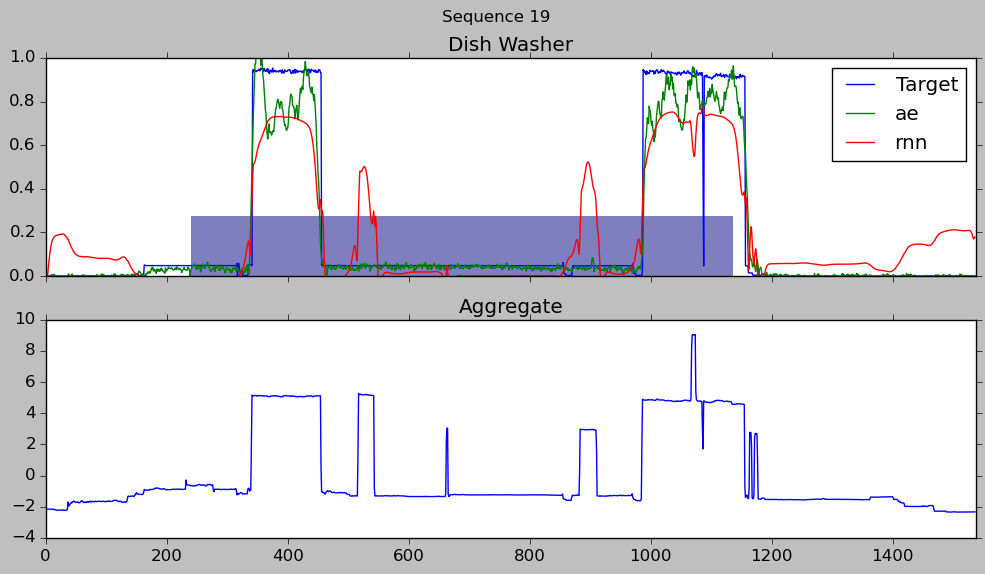

In [227]:
FAVORITES = {'fridge': 23, 'kettle': 23, 'washing machine': 23, 'microwave': 11, 'dish washer': 19}

SEQ_I = 19

# DISH WASHER: 0, 11, 19 are good.
# MICROWAVE: 4, 11, 22, 31, 41, 47, 59 are OK. 10 is good for all nets except rects

if fig is not None:
    plt.close(fig)
fig, axes = plt.subplots(2, sharex=True, figsize=(12,6))
fig.suptitle("Sequence {}".format(SEQ_I))

# Plot target
axes[0].plot(batch.target[SEQ_I, :, 0], label='Target')

# Plot net outputs
for net_name, output in outputs.iteritems():
    if net_name == 'rectangles':
        plot_rectangles(axes[0], output[SEQ_I], plot_seq_width=seq_length, alpha=0.5)
    else:
        axes[0].plot(output[SEQ_I, :, 0], label=net_name)
axes[0].legend()
axes[0].set_ylim((0, 1))
axes[0].set_title(APPLIANCE.title())

# Plot aggregate input
axes[1].plot(batch.input[SEQ_I, :, 0])
axes[1].set_title('Aggregate')
axes[1].set_xlim((0, seq_length))

plt.show()

In [89]:
# 18, 34, 46 is good, but no background
# 41 has background and is bpretty good for AE and rectangles
# 55 has lots of background and is surprisingly good
#np.save('fridge_input_1.npy', batch.input)
#np.save('fridge_target_1.npy', batch.target)

In [90]:
# 0, 4, 6, 13, 15, 18, 19, 26, 27, 29, 52 good but no background
# 40 has lots of background and is pretty good
# 54 has lots of background and is pretty good, not great for RNN though
# 58, 62 aren't terrible
#np.save('fridge_input_2.npy', batch.input)
#np.save('fridge_target_2.npy', batch.target)

In [91]:
# 3, 4, 17, 18, 19, 33, 34, 37, 60 is good and has a fair amount of background
# 15, 16, 24, 26, 38, 44 are interesting!
# 10 not bad
# 22 shows all nets classifying a defrost cycle as a normal fridge cycle
# 62 pretty good (and is a defrost cycle)
# 23, 25, 29, 31 (tricky!), 35, 39, 40, 45, 49, 51, 54, 61 are nice

# FAVORITE = 23
#np.save('fridge_input.npy', batch.input)
#np.save('fridge_target.npy', batch.target)

In [92]:
from neuralnilm.data.stride import stride

In [228]:
fav = FAVORITES[APPLIANCE]
batches = stride(batch.input[fav, :, 0], num_seq_per_batch=64, seq_length=batch.input.shape[1], stride=STRIDE)

In [229]:
len(batches)

5

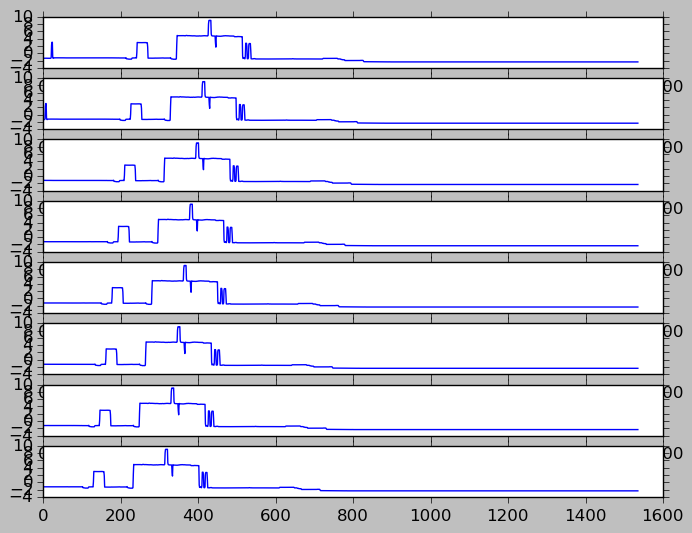

In [234]:
plt.close()
strided_batch = batches[2]
N = 8
fig, axes = plt.subplots(N, sharey=True)
for i in range(N):
    axes[i].plot(strided_batch[i+8, :, 0])
plt.show()

In [236]:
strided_batches = batches[:3]
len(strided_batches)

3

In [237]:
strided_outputs = {}
for net_name, net in nets.iteritems():
    print("Getting output for", net_name)
    outputs_for_net = []
    for strided_batch in strided_batches:
        output = net.deterministic_output_func(strided_batch)
        outputs_for_net.append(output)
    strided_outputs[net_name] = np.concatenate(outputs_for_net, axis=0)

Getting output for rectangles
Getting output for ae
Getting output for rnn


In [238]:
for arch, output in strided_outputs.iteritems():
    np.save(APPLIANCE + '_strided_output_' + arch, output)

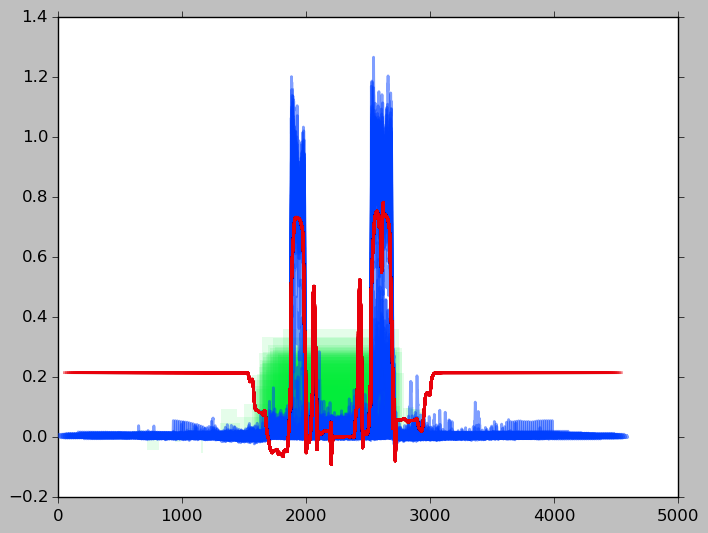

In [239]:
import seaborn as sns
sns.reset_orig()

plt.close()
fig, ax = plt.subplots(1)
seq_length = batch.input.shape[1]
palette = sns.palettes.color_palette('bright', n_colors=3)
for arch_i, (arch, output) in enumerate(strided_outputs.iteritems()):
    num_seq_per_batch = output.shape[0]
    for seq_i in range(num_seq_per_batch):
        start = seq_i * STRIDE
        end = start + seq_length
        x = np.arange(start, end)
        color = palette[arch_i]
        if arch == 'rectangles':
            pass
            plot_rectangles(
                ax, output[seq_i], plot_seq_width=seq_length, offset=start, 
                alpha=0.1, color=color, zorder=0)
            #ax.plot(x, strided_batches[seq_i // 64][seq_i % 64], color='k', linewidth=0.5, alpha=0.05)
        else:
            pass
            if arch == 'ae':
                zorder = 5
                data = output[seq_i, :, 0]
            elif arch == 'rnn':
                zorder = 10
                x = x[50:-50]
                data = output[seq_i, 50:-50, 0]
            ax.plot(x, data, color=color, alpha=0.5, linewidth=2, zorder=zorder)
plt.show()